In [1]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

In [2]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

id_df = read_wandb_csv("data/A_5_diff_eval.csv")
id_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,ID,Group,...,test_f1_best_eval_loss,test_f1_best_f1,train_loss,train_p_max,train_p_var,train_st1_loss,train_st1_p_max,train_st2_loss,train_st2_p_max,vector_norms
0,25_S4_ID_35_VAN,finished,-,ricu,"SWP4, WITH_GRAD, vanilla",2024-01-15T12:42:49.000Z,563,NaN,zl2vd6lh,NaN,...,NaN,NaN,NaN,NaN,NaN,0.570144,0.589064,0.593119,0.578632,"{""_type"":""histogram"",""bins"":[0.000042378702346..."
1,25_S4_ID_34_VAN,finished,-,ricu,"SWP4, WITH_GRAD, vanilla",2024-01-15T12:33:32.000Z,541,NaN,3m8ts2nb,NaN,...,NaN,NaN,NaN,NaN,NaN,0.244251,0.822121,0.293537,0.798043,"{""values"":[148,115,68,53,33,34,12,15,10,2,1,4,..."
2,25_S4_ID_33_VAN,finished,-,ricu,"SWP4, WITH_GRAD, vanilla",2024-01-15T12:24:39.000Z,515,NaN,unqljpv3,NaN,...,NaN,NaN,NaN,NaN,NaN,0.238332,0.823795,0.267198,0.807551,"{""_type"":""histogram"",""bins"":[0.000377135263988..."
3,25_S4_ID_32_VAN,finished,-,ricu,"SWP4, WITH_GRAD, vanilla",2024-01-15T12:14:37.000Z,584,NaN,sxrthk8a,NaN,...,NaN,NaN,NaN,NaN,NaN,0.478398,0.635228,0.515454,0.621283,"{""values"":[58,69,49,55,44,44,48,19,12,20,19,19..."
4,25_S4_ID_31_VAN,finished,-,ricu,"SWP4, WITH_GRAD, vanilla",2024-01-15T12:04:44.000Z,575,NaN,wv1526v6,NaN,...,NaN,NaN,NaN,NaN,NaN,0.372636,0.730539,0.407014,0.714476,"{""_type"":""histogram"",""bins"":[0.000083745799202..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,25_S1_ID_04_MOD,finished,-,ricu,"SWP1, modded",2024-01-13T12:12:22.000Z,493,NaN,4disnxrr,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000244,0.999756,0.000373,0.999627,"{""_type"":""histogram"",""bins"":[0.000001201643954..."
68,25_S1_ID_03_MOD,finished,-,ricu,"SWP1, modded",2024-01-13T12:03:25.000Z,514,NaN,bc8k6bu6,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000302,0.999698,0.000435,0.999565,"{""_type"":""histogram"",""bins"":[6.13419103956403e..."
69,25_S1_ID_02_MOD,finished,-,ricu,"SWP1, modded",2024-01-13T11:55:08.000Z,475,NaN,a5xu6spb,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000166,0.999834,0.000249,0.999751,"{""_type"":""histogram"",""bins"":[2.199809614467085..."
70,25_S1_ID_01_MOD,finished,-,ricu,"SWP1, modded",2024-01-13T11:47:06.000Z,457,NaN,zkupl7pk,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000282,0.999718,0.000382,0.999618,"{""values"":[122,101,86,53,35,32,27,12,13,10,5,6..."


In [4]:
from tqdm import tqdm
run_ids = id_df["ID"]

api = wandb.Api()

all_dfs = []
metrics_train = ["train_st2_loss","avg_grad_diff_all_classes"]
metrics_eval = ["accuracy","eval_loss","eval_p_max"]
metrics_lr = ["learning_rate"]
index_keys = ["_step","epoch"]

# Add tqdm to the loop for progress bar
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the history
    history_train = run.scan_history(keys=metrics_train+index_keys)
    df_run =  pd.DataFrame([row for row in history_train])
    
    history_eval = run.scan_history(keys=metrics_eval+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_eval]), on=['_step', 'epoch'], how='outer')
    
    history_lr = run.scan_history(keys=metrics_lr+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_lr]), on=['_step', 'epoch'], how='outer')
    df_run = df_run.sort_values(by="_step", ascending=True,ignore_index=True)
    # last_step_diff = df_run["_step"].iloc[-1] - df_run["_step"].iloc[-2]
    # first_step_diff = df_run["_step"].iloc[1] - df_run["_step"].iloc[0]
    # if last_step_diff != first_step_diff:
    #     df_run.at[df_run.index[-1], 'train_st2_loss'] = df_run['train_st2_loss'].iloc[-1] / last_step_diff
    df_run["learning_rate"] = df_run["learning_rate"].fillna(0)
    df_run = df_run.rename(columns={'learning_rate': 'scheduled_learning_rate'})
    
    for key, value in run.config.items():
        df_run = df_run.assign(**{key: value})
    
    all_dfs.append(df_run)

df = pd.concat(all_dfs,axis=0,ignore_index=True)
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
with open("data/A_5_diff_eval.pkl",'wb') as f:
    pickle.dump(df,f)

100%|██████████| 72/72 [03:22<00:00,  2.81s/it]


In [5]:
with open("data/A_5_diff_eval.pkl",'rb') as f:
    df = pickle.load(f)
df.head()

,train_st2_loss,avg_grad_diff_all_classes,_step,epoch,accuracy,eval_loss,eval_p_max,scheduled_learning_rate,seed,beta1,...,lr_scheduler_type,pad_to_max_length,model_name_or_path,warmup_steps_fraction,early_stopping_patience,ignore_mismatched_sizes,early_stopping_min_delta,per_device_eval_batch_size,per_device_train_batch_size,mode
0,NaN,NaN,0,-1,0.453613,0.806656,0.662279,1.250000e-08,3,0.9,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,VANILLA
1,0.818610,0.042427,16,1,0.454102,0.805290,0.661413,2.125000e-07,3,0.9,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,VANILLA
2,0.817385,0.043357,32,3,0.456055,0.801284,0.658907,4.125000e-07,3,0.9,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,VANILLA
3,0.794217,0.041298,48,5,0.460938,0.794762,0.654875,6.125000e-07,3,0.9,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,VANILLA
4,0.789658,0.042515,64,7,0.465332,0.786543,0.648755,8.125000e-07,3,0.9,...,linear,False,bert-base-uncased,0.1,800,False,0,128,32,VANILLA


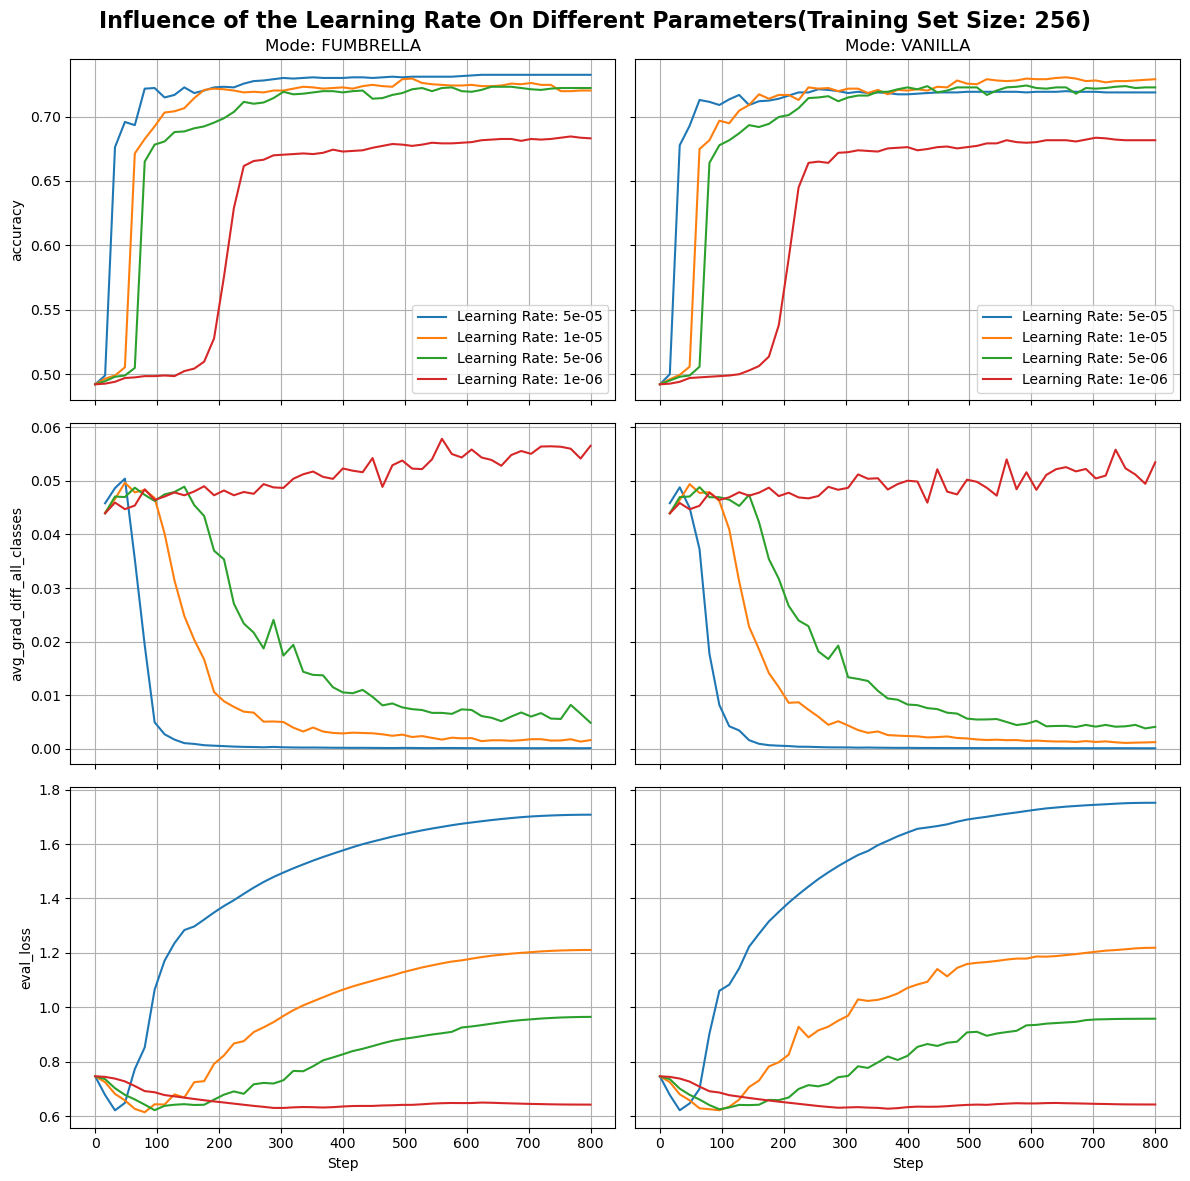

In [14]:
import matplotlib.pyplot as plt
selected_rows = functools.reduce(
    operator.and_,
    [
        df["training_size"] == 256
        # df["Tags"].str.contains('modded')
    ]  
    )
filtered_df = df.loc[selected_rows]

subplot_column_keys = ['VANILLA','MODDED']
subplot_column_names = ['Vanilla Finetuning','REGRADS']
subplot_row_keys = ['accuracy', 'avg_grad_diff_all_classes', 'eval_loss']
subplot_row_names = ['Accuracy', 'L2-Norm of the Difference\nBetween the Stage 1 and 2 Gradient', 'Validation Loss']

# Create a new figure
fig, axs = plt.subplots(
    len(subplot_row_keys),
    len(subplot_column_keys),
    sharex=True,
    sharey='row',
    figsize = (12,12)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, col_key in enumerate(subplot_column_keys):
    grouped_df = filtered_df.loc[df["mode"]==col_key].groupby(["learning_rate","_step"])
    for idx, row_key in enumerate(subplot_row_keys):
        statistics = grouped_df[row_key].agg(['mean', 'median', 'std'])
        statistics = statistics.sort_index(level=["learning_rate"], ascending=False)

        for learning_rate in statistics.index.get_level_values('learning_rate').unique():
            stats = statistics.loc[learning_rate]
            axs[idx,idy].plot(
                stats.index,
                stats["median"],
                label=f'Learning Rate: {learning_rate}'
                )

        if idy == 0:
            axs[idx,idy].set_ylabel(subplot_row_names[idx])
        if idx == 0:
            axs[idx,idy].set_title(f'Mode: {subplot_column_names[idy]}')
        if idx == len(subplot_row_keys) - 1:
            axs[idx,idy].set_xlabel('Step')

        if row_key == 'learning_rate':
            axs[idx,idy].set_yscale('log')
        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()


fig.suptitle('Influence of the Learning Rate On Different Parameters(Training Set Size: 256)', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_5_diff.pdf', format='pdf')
plt.show()